In [52]:
import xarray as xr # for data handling
import numpy as np # for maths
import matplotlib as mpl # plotlibrary
import matplotlib.pyplot as plt # for the plots 
from matplotlib.patches import Rectangle
from matplotlib.colors import LogNorm # for making a log 10 colorscale
import cartopy # library for making maps
from cartopy import crs as ccrs # Projection Library
from cartopy.crs import Stereographic, PlateCarree, Mollweide # Map projections I use00
from cartopy.feature import LAND, COASTLINE # Vectordata of the Coastline and land for making the maps prettier
import cmocean
from glob import glob
import dask
from scipy.io import loadmat

# Exercise 1

In [42]:
mimoc_files = glob("./MIMOC_ML_v2.2_PT_S/*")
mimoc = xr.open_mfdataset(mimoc_files, combine="nested", concat_dim="month")
mimoc

<xarray.Dataset> Size: 35MB
Dimensions:                            (month: 12, LAT: 341, LONG: 720)
Dimensions without coordinates: month, LAT, LONG
Data variables:
    LATITUDE                           (month, LAT) float32 16kB dask.array<chunksize=(1, 341), meta=np.ndarray>
    LONGITUDE                          (month, LONG) float32 35kB dask.array<chunksize=(1, 720), meta=np.ndarray>
    SALINITY_MIXED_LAYER               (month, LAT, LONG) float32 12MB dask.array<chunksize=(1, 341, 720), meta=np.ndarray>
    POTENTIAL_TEMPERATURE_MIXED_LAYER  (month, LAT, LONG) float32 12MB dask.array<chunksize=(1, 341, 720), meta=np.ndarray>
    DEPTH_MIXED_LAYER                  (month, LAT, LONG) float32 12MB dask.array<chunksize=(1, 341, 720), meta=np.ndarray>

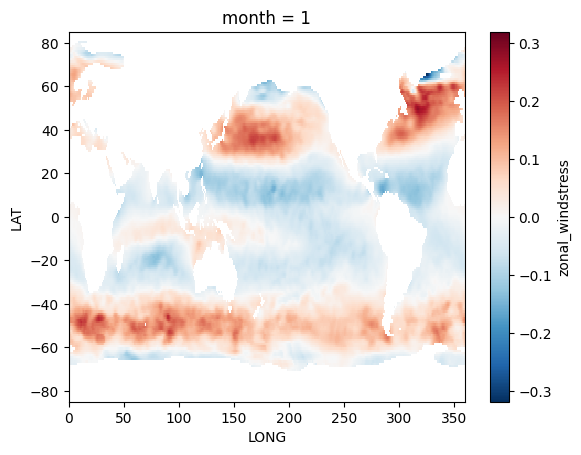

In [ ]:
lats = loadmat("./atae.mat").get("lat").T[0]
lons = loadmat("./atae.mat").get("lon").T[0]
months = np.arange(1,13)
windstress = xr.Dataset(
    data_vars=dict(
        zonal_windstress=(["LAT","LONG","month"], loadmat("./atae.mat").get("atae")),
        meridional_windstress=(["LAT","LONG","month"], loadmat("./atae.mat").get("atae")),
        ),
    coords=dict(
        LAT=("LAT", lats),
        LONG=("LONG", lons),
        month=("month", months),
    ),
).sortby("LONG")

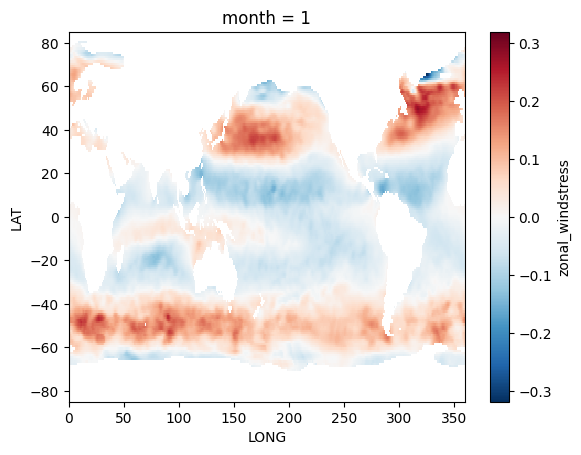

In [134]:
windstress.zonal_windstress.isel(month=0).plot()

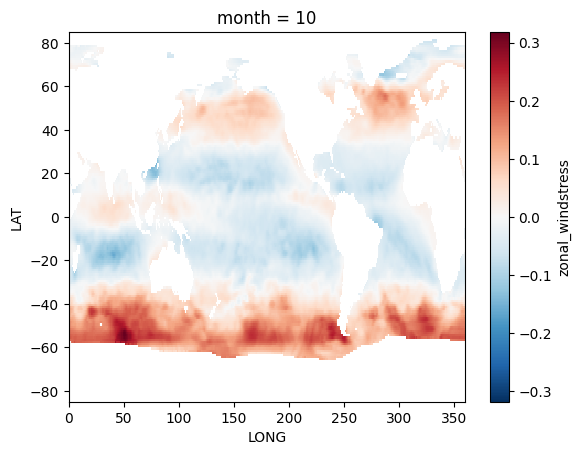

In [ ]:
windstress.zonal_windstress.isel(month=9).plot()

In [ ]:
# Read levitus files (only works, when in same folder as this notebook)
levitus_file = "Levitus_climatology.nc"
levitus = xr.open_dataset(levitus_file, engine="scipy", decode_times=False)
levitus = levitus.rename({"X": "lon", "Y": "lat"}) # Rename the dimensions for easier understanding 

ocean_atmosphere_heat_flux_file = "Ocean-atmosphere_heat-flux.nc"
windstress = xr.open_dataset(ocean_atmosphere_heat_flux_file, engine="scipy", decode_times=False)
windstress = windstress.rename({"Y": "lat"}) # Rename the dimensions for easier understanding 

# Not yet used
mimoc_file = "MIMOC_Z_GRID_v2.2_PT_S_month01.nc"
mimoc = xr.open_dataset(mimoc_file, decode_times=False)

In [73]:
# Define given values
specific_heat_capacity = 3.94e3
density = 1024

# get nice colormaps
cm_thermal = cmocean.cm.thermal
cm_balance = cmocean.cm.balance

In [74]:
# Set the basic mapping parameters
suptitle_size = 20 # Size for the main title 
title_size = 16 # Size for fonts
map_size = (16, 4) 
map_projection = Mollweide()

# Define a function that gives basic mapping parameters like land, coastline and gridlines
def basemap(ax):
        ax.add_feature(LAND)
        ax.add_feature(COASTLINE)
        ax.gridlines(
                draw_labels=["left", "bottom"], 
                y_inline=False, x_inline=False
        ) # Labels for  the coordinates are not within the map, but outside
        return ax

In [7]:
# Integrate Temperature over the topmost 1000 meters
integrated_temperature = (
    levitus
    .sel(Z=slice(0,1000)) # Select only the values within the topmost 1000 meters
    .integrate(coord="Z") # Integrate over the depth
    .temp # Take the Value
).T # transpose the data

In [8]:
# Calculate the Change in ocean heatcontent over JJA (August - June) and DJF (Feb - Dec) respectively
seconds_per_day = 24*60*60
days_in_long_month = 31
days_in_short_month = 30
days_in_february = 28

ocean_heatcontent_change_JJA = (
        density * specific_heat_capacity * 
        (
                integrated_temperature.sel(T=7.5) -
                integrated_temperature.sel(T=5.5)
        )
)
ocean_heatcontent_change_DJF = (
        density * specific_heat_capacity * 
        (
                integrated_temperature.sel(T=1.5) -
                integrated_temperature.sel(T=11.5)
        )
)

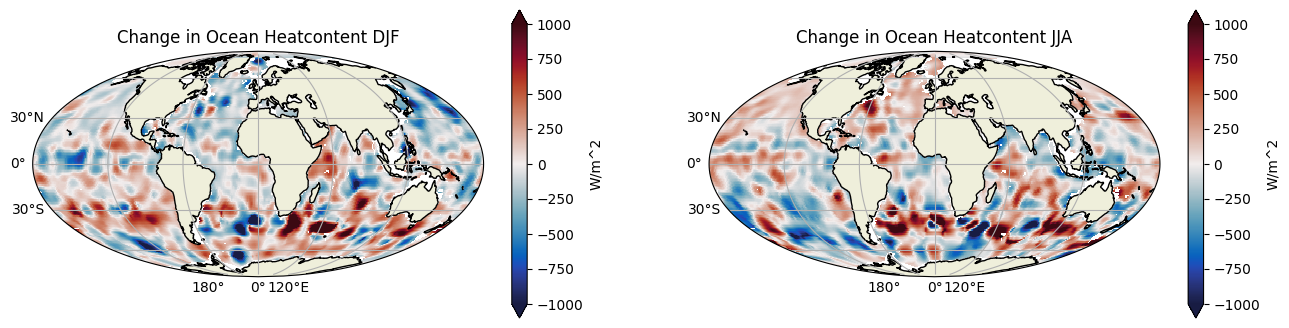

In [ ]:
fig = plt.figure(figsize=mapsize)
ax1 = fig.add_subplot(121, projection=Mollweide())
basemap(ax1)
ocean_heatcontent_change_DJF.plot(ax=ax1, transform=PlateCarree(), vmin=-1.5e10, vmax=1.5e10, cmap="bwr")
ax1.set_title("Change in Ocean Heatcontent DJF, (0-1000m)")
ax2 = fig.add_subplot(122, projection=Mollweide())
basemap(ax2)
ocean_heatcontent_change_JJA.plot(ax=ax2, transform=PlateCarree(), vmin=-1.5e10, vmax=1.5e10, cmap="bwr")
ax2.set_title("Change in Ocean Heatcontent JJA, (0-1000m)")
plt.show()

In [ ]:
# change the coordinates from -180 - 180 to 0 -360
windstress["lon"] = xr.where(
    windstress["X"]<0, # take all the values, where X is less than zero
    windstress["X"]+360, # if true, add 360
    windstress["X"], # if false take them verbatim
)
windstress = (
    windstress
    .swap_dims({"X": "lon"}) # Make the new values to our dimension
    .sel(**{"lon":sorted(windstress.lon)}) # make sure to sort them
    .drop("X") # drop the old Dimension
)

/tmp/ipykernel_1983/3222429202.py:11: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  .drop("X") # drop the old Dimension


In [ ]:
# Get the total heat by multiplying eachs month value with the number of days in that month, 
# summing everything and then multiply by 24*60*60, as the unit is given per second
heatflux_DJF = (
    (windstress.hfns.isel(T=11).T + windstress.hfns.isel(T=0).T) * 31 + 
    windstress.hfns.isel(T=1).T * 28
    ).T *24*60*60
heatflux_JJA = (
    (windstress.hfns.isel(T=6).T + windstress.hfns.isel(T=7).T)*31 +
    windstress.hfns.isel(T=5).T*30
    ).T *24*60*60

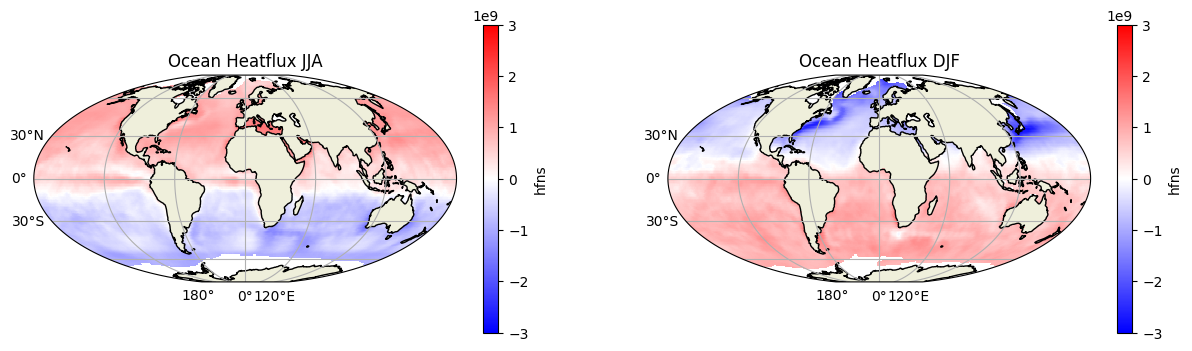

In [85]:
fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_subplot(121, projection=Mollweide())
basemap(ax1)
heatflux_JJA.plot(ax=ax1, transform=PlateCarree(), vmin=-3e9, vmax=3e9, cmap="bwr")
ax1.set_title("Ocean Heatflux JJA")
ax2 = fig.add_subplot(122, projection=Mollweide())
basemap(ax2)
heatflux_DJF.plot(ax=ax2, transform=PlateCarree(), vmin=-3e9, vmax=3e9, cmap="bwr")
ax2.set_title("Ocean Heatflux DJF")
plt.show()

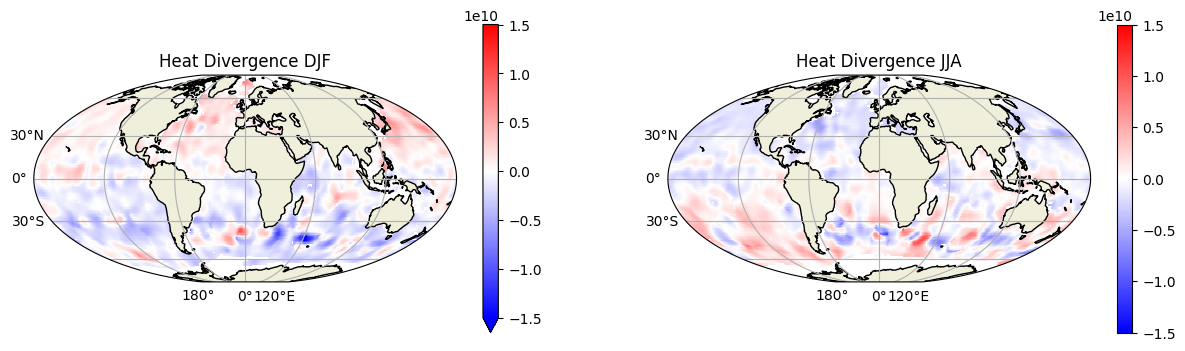

In [86]:
fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_subplot(121, projection=Mollweide())
basemap(ax1)
(-heatflux_DJF-ocean_heatcontent_change_DJF).plot(ax=ax1, transform=PlateCarree(), vmin=-1.5e10, vmax=1.5e10, cmap="bwr")
ax1.set_title("Heat Divergence DJF")
ax2 = fig.add_subplot(122, projection=Mollweide())
basemap(ax2)
(-heatflux_JJA-ocean_heatcontent_change_JJA).plot(ax=ax2, transform=PlateCarree(), vmin=-1.5e10, vmax=1.5e10, cmap="bwr")
ax2.set_title("Heat Divergence JJA")
plt.show()

# Excerscise 2

In [87]:
gravitational_acceleration = 9.81
(-heatflux_DJF-ocean_heatcontent_change_DJF)

<xarray.DataArray (lat: 170, lon: 360)> Size: 245kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]],
      shape=(170, 360), dtype=float32)
Coordinates:
  * lat      (lat) float32 680B -84.5 -83.5 -82.5 -81.5 ... 81.5 82.5 83.5 84.5
  * lon      (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    T        float32 4B 1.5

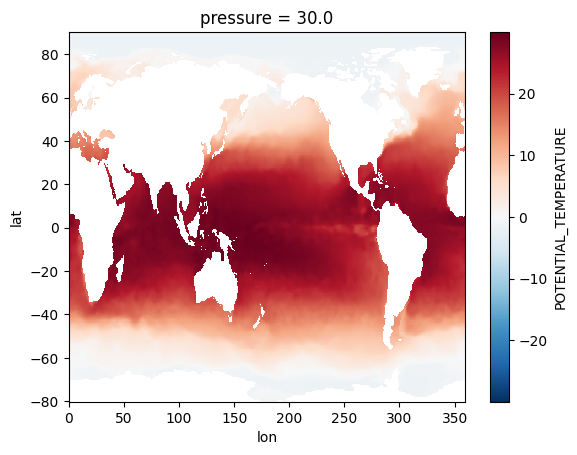

In [88]:
mimoc_dimensions = mimoc.set_coords([
        "LATITUDE", "LONGITUDE", "PRESSURE",
    ]).set_index(indexes={
        "LAT":"LATITUDE", "LONG": "LONGITUDE", "PRES": "PRESSURE",
    }).rename_dims({
        "LAT":"lat", "LONG":"lon", "PRES":"pressure"
    }).rename_vars({
        "LAT":"lat", "LONG":"lon", "PRES":"pressure"
    })

mimoc_dimensions.POTENTIAL_TEMPERATURE.sel(pressure=30, method="nearest").plot()

In [44]:
levitus

<xarray.Dataset> Size: 59MB
Dimensions:  (T: 12, X: 360, Y: 180, Z: 19)
Coordinates:
  * T        (T) float32 48B 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5
  * X        (X) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * Y        (Y) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * Z        (Z) float32 76B 0.0 10.0 20.0 30.0 50.0 ... 700.0 800.0 900.0 1e+03
Data variables:
    temp     (T, X, Y, Z) float32 59MB ...

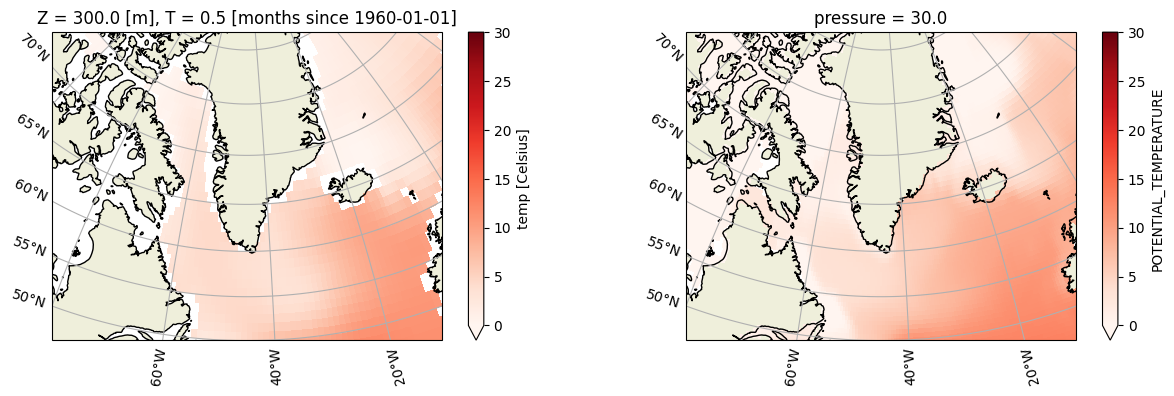

In [89]:
north, south, east, west = 80, 50, 350, 280
map_projection_greenland = Stereographic(central_longitude=(east+west)/2, central_latitude=(north-south)/2)
fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_subplot(121, projection=map_projection_greenland)
basemap(ax1)
ax1.set_extent([west, east, south, north], crs=PlateCarree())
levitus.isel(T=0).temp.sel(
    Z=345, method="nearest"
    ).plot(ax=ax1, transform=PlateCarree(), x="lon", y="lat", cmap="Reds", vmin=0, vmax=30)
ax2 = fig.add_subplot(122, projection=map_projection_greenland)
basemap(ax2)
ax2.set_extent([west, east, south, north], crs=PlateCarree())
mimoc_dimensions.POTENTIAL_TEMPERATURE.sel(
    pressure=30, method="nearest"
    ).plot(ax=ax2, transform=PlateCarree(), x="lon", y="lat", cmap="Reds", vmin=0, vmax=30)


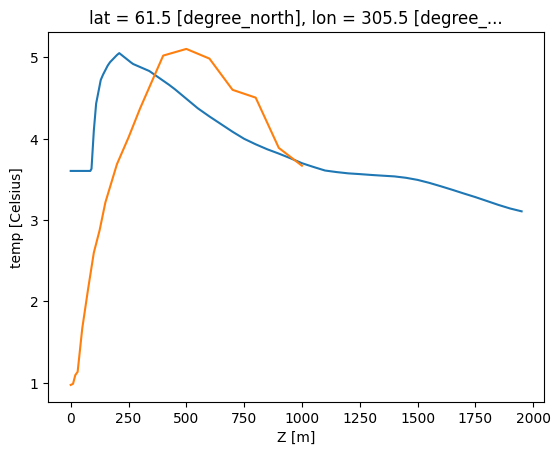

In [95]:
mimoc_dimensions.sel(lat=61, lon=305, method="nearest").POTENTIAL_TEMPERATURE.plot()
levitus.sel(lat=61, lon=305, T=0.5, method="nearest").temp.plot()
plt.show()